## Sensibilidade CATEGORY

### Goal: Estimate elasticity per category (MED and N-MED)

In [2]:
pip install pyathena holidays cachetools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.4/932.4 kB 16.8 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
from pyathena import connect
import boto3 ### AWS acces to s3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import statsmodels.api as sm
from matplotlib.ticker import PercentFormatter

from sklearn import linear_model
from sklearn.metrics import r2_score
import statsmodels.api as sm

### 
import os

from utils_panvel import sql_query
import holidays

# Supressing warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from pyathena import connect
import boto3 ### AWS acces to s3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import statsmodels.api as sm
from matplotlib.ticker import PercentFormatter

from sklearn import linear_model
from sklearn.metrics import r2_score
import statsmodels.api as sm

### 
import os

from utils_panvel import sql_query
import holidays

# Supressing warnings
import warnings
warnings.filterwarnings("ignore")

%%time
df = sql_query(open("sensibilidade_all.sql", "r").read())

In [4]:
### Overall options

pd.options.display.float_format = "{:,.2f}".format

## Load dataset 

In [5]:
%%time
df = sql_query(open("sensibilidade_all.sql", "r").read())

Result loaded from cache.
CPU times: user 5.01 s, sys: 898 ms, total: 5.91 s
Wall time: 11.8 s


In [6]:
### Extract daf stats

def simple_stats (df):
    print('\nTotal datapoints:', df.shape[0])
    print('\nTotal de items:', df.codigo_item.nunique())
    print('\nTotal de categorias:', df.categoria.nunique())
    
simple_stats(df)


Total datapoints: 2222342

Total de items: 11872

Total de categorias: 289


## Part A. Data formating / cleaning / filtering

In [7]:
## declare variáveis
df['data_emissao'] = pd.to_datetime(df['data_emissao'])
df[['quant','price']] = df[['quant', 'price']].apply(pd.to_numeric)

In [8]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})

missing_value_df

,column_name,percent_missing
data_emissao,data_emissao,0.00
codigo_item,codigo_item,0.00
categoria,categoria,0.00
tipo_produto_gerencial,tipo_produto_gerencial,0.00
quant,quant,0.00
price,price,0.00
rent,rent,0.00
total_items_with_discount,total_items_with_discount,0.00
ratio_discount,ratio_discount,0.00


### Filter 0 -  Flag special dates (holidays, blackfriday)

In [9]:
### black friday
start_date_23 = '2023-11-15'
end_date_23 =  '2023-11-30'
mask_23 = (df['data_emissao'] >= start_date_23) & (df['data_emissao'] <= end_date_23)

### Gov 
gov_date_23 = '2023-03-31'
gov_23 = (df['data_emissao'] == gov_date_23) 

## Brazilain Holidays
feriados = holidays.country_holidays("BR")
feriados_23 = feriados["2023-01-01":"2024-01-30"]

# Add a new column for holidays
df.loc[df['data_emissao'].isin(feriados_23), 'special_dates'] = 1
df.loc[gov_23, 'special_dates'] = 1
df.loc[mask_23, 'special_dates'] = 1

## Replace boolean with an integer
df.special_dates = df.special_dates.replace({True: 1, np.nan: 0}).astype(int)

## Filter out nspecial dates
df = df[df['special_dates'] == 0]
df

,data_emissao,codigo_item,categoria,tipo_produto_gerencial,quant,price,rent,total_items_with_discount,ratio_discount,special_dates
0,2023-03-01,940690,TINTURA,NI,15.00,23.93,11.526667,15.0000,100.0000,0
1,2023-03-01,111297,HIDRATANTES.,NI,3.00,66.72,21.963333,1.0000,33.3300,0
2,2023-03-01,119114,CREME PREVENTIVO P/ASSADURAS,NI,12.00,46.39,20.111000,7.0000,58.3300,0
3,2023-03-01,104915,ANTI-IDADE,NI,5.00,119.99,47.420000,0.0000,0.0000,0
4,2023-03-01,120190,C1 - BARBITURICO,MARCA,1.00,90.67,27.750000,1.0000,100.0000,0
...,...,...,...,...,...,...,...,...,...,...
2222337,2024-03-01,112719,REMOVEDOR,NI,460.00,6.90,3.081135,40.0000,8.7000,0
2222338,2024-03-01,845990,AZIA E MA DIGESTAO,MARCA,262.00,3.11,1.027490,6.0000,2.2900,0
2222339,2024-03-01,659630,HIDRATANTES.,NI,22.00,15.88,5.501364,1.0000,4.5500,0
2222340,2024-03-01,97142,FACE,NI,51.00,33.68,13.949216,10.0000,19.6100,0


### Filter 1 - Extract sales frequency per category
* Keep categories that had sales in at least 50% of the analyzed period

In [10]:
## Criar range da data para calcular frequencia de compra

### Total days

# range_analise = (
#      df["data_emissao"].max() - df["data_emissao"].min()
#  ) / np.timedelta64(1, "D") +1

# business_days = len(pd.bdate_range(df["data_emissao"].min(), df["data_emissao"].max()))
# business_days

days = df['data_emissao'].nunique()

stats = df.groupby(['categoria'], dropna=False, as_index=True, sort=True).agg(
    {
        "data_emissao": ["nunique"],
        "codigo_item": ["nunique"],
    }
)

stats.columns = stats.columns.droplevel(1)
stats.reset_index(inplace=True)
stats.rename(columns={'data_emissao': '#_dias', 'codigo_item': '#_items'}, inplace = True)
stats['dias_freq'] = (stats['#_dias'] / days )*100

In [11]:
print('\n Total de categorias:', df.categoria.nunique(),
      '\n Total de categorias com 80% de frequência:', len(stats[stats['dias_freq']>=80]),
      '\n Total de categorias com 90% de frequência:', len(stats[stats['dias_freq']>=90]),
      '\n Total de categorias com 10% de frequência:', len(stats[stats['dias_freq']<30]),
      '\n Média frequência de vendas por categoria {:.2f}\n'.format(round(stats.dias_freq.mean(), 2)))



 Total de categorias: 289 
 Total de categorias com 80% de frequência: 254 
 Total de categorias com 90% de frequência: 249 
 Total de categorias com 10% de frequência: 16 
 Média frequência de vendas por categoria 91.71



### List of categories that will be fitlter out due to lack od sales frequency

In [12]:
print(stats[stats['dias_freq'] <=50]['categoria'].unique())
    
stats[stats['dias_freq'] <=50]['categoria'].unique().shape[0]

['ACESSORIOS DE VERAO' 'ARTROSE E REUMATISMO' 'CALCINHA ABSORVENTE'
 'CICATRIZANTE' 'CINTA' 'COLETE' 'CREME P/ PES' 'CREME PARA PERNAS'
 'DESODORANTE.' 'DISCOS CALMANTES' 'ESFOLIANTE' 'HIDRATANTE FACIAL.'
 'HIDRATANTES FACIAIS' 'KIT MAQUIAGEM' 'KIT TRATAMENTO FACIAL'
 'KITS PRODUTOS PARA O CORPO' 'KITS SABONETE E ACESSORIOS' 'LIMPADOR'
 'MASSAGEM' 'MODIFICADOR' 'REMOVEDOR DE MANCHAS' 'REVISTA' 'SONDA'
 'TONICO' 'TRONCO']


25

### Apply Filter 1

In [13]:
days = df['data_emissao'].nunique()

stats = df.groupby(['categoria'], dropna=False, as_index=True, sort=True).agg(
    {
        "data_emissao": ["nunique"],
        "codigo_item": ["nunique"],
    }
)

stats.columns = stats.columns.droplevel(1)
stats.reset_index(inplace=True)
stats.rename(columns={'data_emissao': '#_dias', 'codigo_item': '#_items'}, inplace = True)
stats['dias_freq'] = (stats['#_dias'] / days )*100


df_filter = stats[['categoria', 'dias_freq']]

df_1  = pd.merge(df, df_filter, left_on='categoria', right_on='categoria', how='left')

df_1 = df_1[df_1['dias_freq'] >=50]

### Extract df stats
simple_stats(df_1)


Total datapoints: 2040294

Total de items: 11819

Total de categorias: 264


### Filter 2: Apply price and quantity dispersion filters (itens)

* Exclude items that deviate from the average category 

    * Filter 2.1 $\rightarrow$ Filter out items whose prices differ greatly from the average price of the category
    * Filter 2.2 $\rightarrow$ Filter out items with low sales quantity by category

In [14]:
### identificar preços médios e quantidade total vendida por item 

share_item = df_1.groupby(['categoria', 'codigo_item'], dropna=False, as_index=True, sort=True).agg(
    {
        "quant": ["sum"],
        "price": ["mean"]
    }
)

share_item.columns = share_item.columns.droplevel(1)
share_item.reset_index(inplace=True)

###########################################

### identificar  métricas de categoria 
share_cat = df_1.groupby(['categoria'], dropna=False, as_index=True, sort=True).agg(
    {
        "codigo_item": ["nunique"],
        "quant": ["sum"],
        "price": ["mean", 'std'],
    }
)

share_cat.columns = share_cat.columns.droplevel(1)
share_cat.reset_index(inplace=True)
#share_cat.rename(columns={'quant': 'quant_cat','codigo_item': '#_itens_cat', 'price': 'avg_price_cat'}, inplace = True)
share_cat.columns = ['categoria', "#_items_cat", "quant_cat", "price_cat", 'std_price_cat']
###########################################

df_share  = pd.merge(share_item, share_cat, left_on='categoria', right_on='categoria', how='left')
df_share['share_quant'] = (df_share['quant']  / df_share['quant_cat'])  * 100

### Filter 2.1 - Price dispersion

In [15]:
zscores = (df_share["price"]-df_share["price_cat"])/df_share["std_price_cat"]
df_share["outlier"] = zscores.abs()>1.0

## Replace boolean with an integer
df_share.Outlier = df_share.outlier.replace({True: 1, False: 0})

## Keep only non-outliers
df_share_1 = df_share[df_share['outlier']==0]

simple_stats(df_share_1)


Total datapoints: 8945

Total de items: 8945

Total de categorias: 264


### Filter 2.2 -  Relative minimum quantity threshold

In [16]:
items = list(set(df_share_1['categoria']))

for i in items:
    df_share_1["rank"] = df_share_1["share_quant"].rank(method="first")
    df_share_1["rank"] = df_share_1["share_quant"].transform(
        lambda x: pd.qcut(
            x.rank(method="first"), q=5, labels=[1, 2, 3, 4, 5]
        )
    )

df_share_2 = df_share_1[df_share_1['rank']>3]

simple_stats (df_share_2)


Total datapoints: 3578

Total de items: 3578

Total de categorias: 264


In [17]:
### Identify selected itens 

df_share_2['selected']=1
df_selected = df_share_2[['codigo_item','selected']]
df_selected

,codigo_item,selected
0,3841,1
2,101063,1
4,103916,1
5,103922,1
6,104610,1
...,...,...
11801,557770,1
11806,669370,1
11812,878990,1
11817,103020,1


## Part B. Estimate Elasticity (per item)

### Merge with original df and extract sales for only selected itens

In [18]:
df_elast = pd.merge(df, df_selected, left_on = 'codigo_item', right_on = 'codigo_item', how = 'left')
df_elast = df_elast[df_elast['selected']==1]
df_elast
# df_elast[df_elast['codigo_item']==106505]

,data_emissao,codigo_item,categoria,tipo_produto_gerencial,quant,price,rent,total_items_with_discount,ratio_discount,special_dates,selected
0,2023-03-01,940690,TINTURA,NI,15.00,23.93,11.526667,15.0000,100.0000,0,1.00
2,2023-03-01,119114,CREME PREVENTIVO P/ASSADURAS,NI,12.00,46.39,20.111000,7.0000,58.3300,0,1.00
3,2023-03-01,104915,ANTI-IDADE,NI,5.00,119.99,47.420000,0.0000,0.0000,0,1.00
7,2023-03-01,109522,APARELHO DEPILATORIO,NI,14.00,24.76,8.590000,2.0000,14.2900,0,1.00
8,2023-03-01,105659,ACESSORIOS FACIAIS,NI,6.00,41.99,17.210000,2.0000,33.3300,0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
2041955,2024-03-01,100977,BALA,NI,77.00,3.38,1.547922,12.0000,15.5800,0,1.00
2041956,2024-03-01,102968,CALCIO E MINERAIS,MARCA,45.00,82.55,24.292093,39.0000,86.6700,0,1.00
2041957,2024-03-01,112719,REMOVEDOR,NI,460.00,6.90,3.081135,40.0000,8.7000,0,1.00
2041958,2024-03-01,845990,AZIA E MA DIGESTAO,MARCA,262.00,3.11,1.027490,6.0000,2.2900,0,1.00


Now, we have the items that make up each of the categories.

* Questions: 1. Would it be useful to save the items that make up each of the baskets in a file? assess category composition over time and understandos how it evolves dynamically.

### Log-Log linear regression - estimated beta (slope) is the estimated elasticity

In [19]:
%%time

### Run regression models

df_elast['log_q'] = np.log(df_elast['quant'])
df_elast['log_price'] = np.log(df_elast['price'])
### Iterate per item

df_index = []
coef_mtr = []
r2_mtr = []

items = list(set(df_elast['codigo_item']))
for i in items:
    #print('\n Codigo item', i)
    df_redux = df_elast[df_elast['codigo_item']==i]
    #  print(df_redux)
    X = df_redux[['log_price']]
    Y = df_redux['log_q']

    # Store parameters
#     elast_coef =  regr.coef_

#     coef_mtr.append(elast_coef)
#     df_index.append(i)

    # with statsmodels
    X = sm.add_constant(X) # adding a constant
    model = sm.OLS(Y, X).fit()
    predictions = model.predict(X)
    r2 = model.rsquared
    elast_coef =  model.params
   # print(model.summary())
    
    # Store reulsts
    coef_mtr.append(elast_coef)
    r2_mtr.append(r2)
    df_index.append(i)

r2_mtr= pd.DataFrame(r2_mtr, index =list(set(df_elast['codigo_item'])) )
coef_mtr = pd.DataFrame(coef_mtr, index =list(set(df_elast['codigo_item'])) )

# r2_mtr.index = list(set(df_ols['codigo_item']))

results = pd.merge(coef_mtr, r2_mtr, left_index=True, right_index=True)
results.rename(columns = {'log_price':'elasticity_price',0 :'r2_score'}, inplace = True)

CPU times: user 5min 22s, sys: 30.6 ms, total: 5min 22s
Wall time: 5min 23s


In [24]:
results

,const,elasticity_price,r2_score
106499,16.59,-3.59,0.68
106500,17.72,-3.76,0.76
106504,16.20,-4.82,0.09
106505,21.30,-4.51,0.48
516110,3.76,0.02,0.00
...,...,...,...
106486,0.80,-0.13,0.00
401401,11.53,-2.28,0.36
114682,6.61,-1.16,0.13
98294,5.33,-0.94,0.15


In [20]:
# results.reset_index(inplace=True)
results[results['r2_score'] >= 0.5]

,const,elasticity_price,r2_score
106499,16.59,-3.59,0.68
106500,17.72,-3.76,0.76
417830,8.65,-1.32,0.57
983080,43.20,-9.78,0.51
868410,12.40,-2.86,0.52
...,...,...,...
98126,9.43,-3.93,0.58
98133,8.92,-2.45,0.54
622500,10.84,-3.86,0.62
106481,11.55,-2.24,0.50


### Debug results

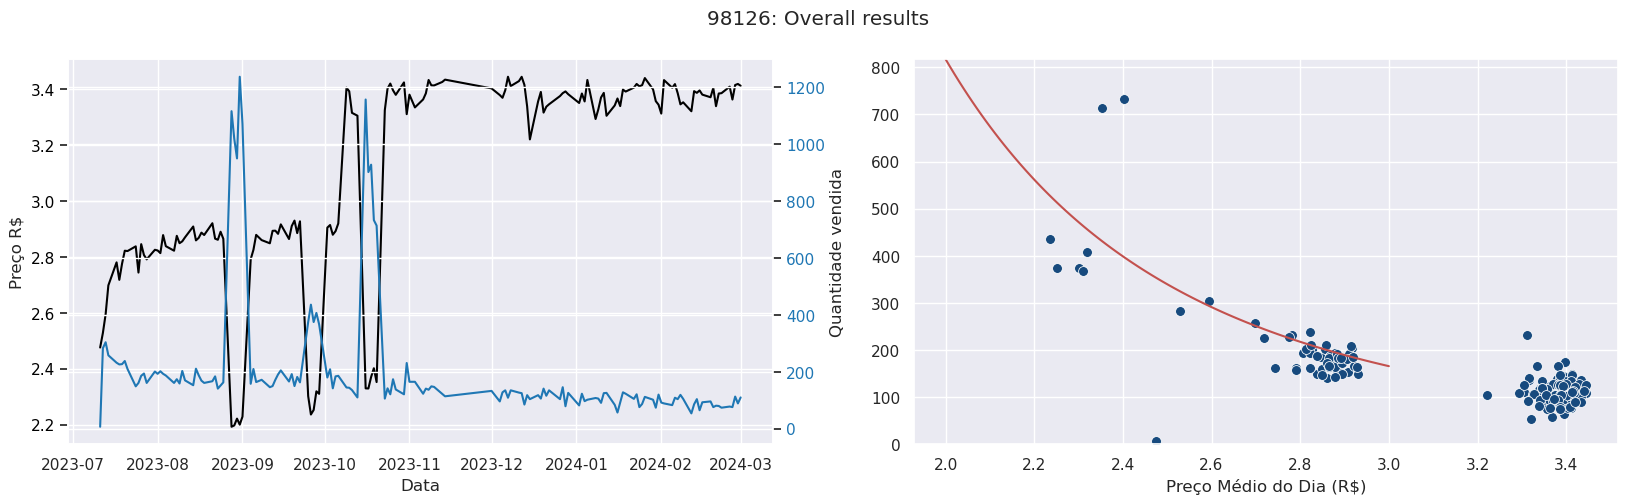

In [21]:
### View some data
result_item = results.reset_index()
result_item .rename(columns={'index': 'codigo_item'}, inplace = True)

item = 98126
result_item= result_item[result_item['codigo_item']== item]

intercept = result_item['const'].values
slope = result_item['elasticity_price'].values

df_item = df_elast[df_elast['codigo_item']== item]

preco_min = int(df_item['price'].min())
preco_max = int(df_item['price'].max())

# Calculate the y-values for the endpoints of the curve using the slope and intercept
x_line = np.linspace(preco_min, preco_max, 100)
y_line = np.exp(intercept) * (x_line ** (slope))

# Create subplots with two axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

## First plot
### 1 y-axis
color = 'black'
ax1.set_xlabel('Data')
ax1.set_ylabel('Preço R$')
ax1.plot(df_item['data_emissao'], df_item['price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

### 2 y-axis
ax1twin = ax1.twinx()
color = 'tab:blue'
ax1twin .set_ylabel('Quantidade vendida')
ax1twin .plot(df_item['data_emissao'], df_item['quant'], color=color)
ax1twin .tick_params(axis='y', labelcolor=color)

## Second plot
sns.scatterplot(x='price', y='quant', data=df_item, s=50, color = '#174A7E', ax=ax2)
ax2.set_ylim(0, y_line.max())
ax2.plot(x_line, y_line, color='#C3514E', label='Curva de Demanda')

ax2.set_ylabel('')
ax2.set_xlabel('Preço Médio do Dia (R$)')


plt.suptitle(f'{item}: Overall results')
plt.show()

## Part C - Extract category elasticity

### Strategy A: All itens


In [39]:
itens_selected_A = results.copy()
print('Total itens:', len(itens_selected_A))

Total itens: 3578


Text(0.5, 1.0, 'Strategy A - Selected itens R2')

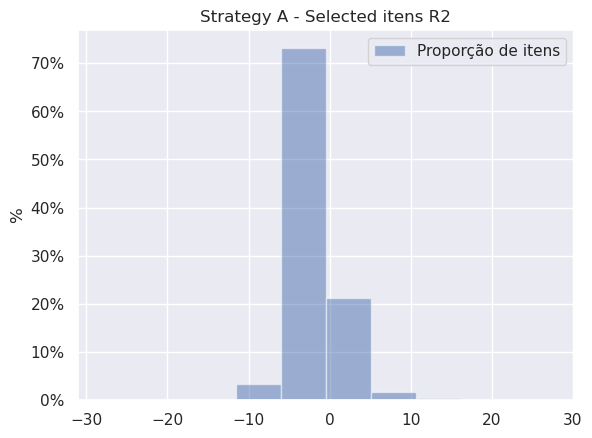

In [40]:
plt.hist(
    itens_selected_A["elasticity_price"],
    bins=10,
    alpha=0.5,
    label="Proporção de itens",
    weights=np.ones(len(itens_selected_A)) / len(itens_selected_A),
)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend(loc="upper right")
plt.ylabel("%")
plt.title("Strategy A - Selected itens R2")

Text(0.5, 1.0, 'Elasticidade - % de itens')

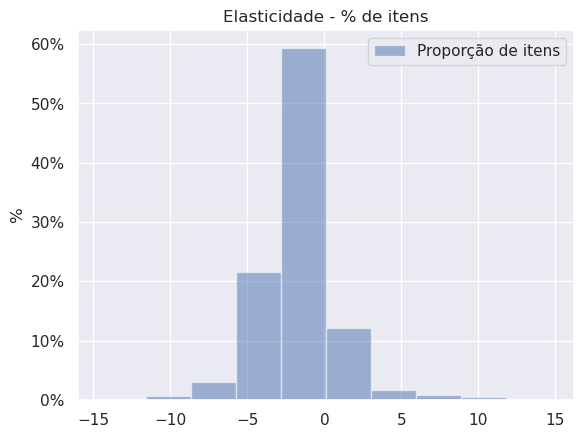

In [50]:
itens_selected_A_filter = itens_selected_A[(itens_selected_A["elasticity_price"] >= - 15) & (itens_selected_A["elasticity_price"] <= 15)]

itens_selected_A_filter


plt.hist(
    itens_selected_A_filter["elasticity_price"],
    bins=10,
    alpha=0.5,
    label="Proporção de itens",
    weights=np.ones(len(itens_selected_A_filter)) / len(itens_selected_A_filter),
)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend(loc="upper right")
plt.ylabel("%")
plt.title("Elasticidade - % de itens")

### Extract category elasticity

In [42]:
df_elast_cat_A = df_elast[['categoria', 'codigo_item']].drop_duplicates(subset=['codigo_item'], keep='first')
itens_selected_A = itens_selected_A.reset_index()
itens_selected_A.rename(columns={'index': 'codigo_item'}, inplace = True)


df_elast_cat_A = pd.merge(itens_selected_A, df_elast_cat_A, left_on='codigo_item', right_on = 'codigo_item' )

#Drop possible duplicates
# df.drop_duplicates(subset=['concat'], keep='first', inplace=True)
simple_stats(df_elast_cat_A)


Total datapoints: 3578

Total de items: 3578

Total de categorias: 264


In [43]:
stats_elast_cat_A = df_elast_cat_A.groupby(['categoria'], dropna=False, as_index=True, sort=True).agg(
    {
        "elasticity_price": ["mean"],
        "r2_score": ["mean"],
    }
)

stats_elast_cat_A.columns = stats_elast_cat_A.columns.droplevel(1)
# #stats_elast_cat.reset_index(inplace=True)

stats_elast_cat_A.to_parquet('elasticity_category.parquet')

stats_elast_cat_A

,elasticity_price,r2_score
categoria,,
A1 - BARBITURICO,-0.57,0.02
A2 - BARBITURICO,-1.33,0.17
A3 - BARBITURICO,-1.68,0.03
ABSORVENTE EXTERNO,-1.67,0.29
ABSORVENTE INTERNO,-2.76,0.26
...,...,...
UNHAS E ACESSORIOS,-0.38,0.04
UTILIDADES,-0.84,0.20
VERRUGAS,-1.83,0.04


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


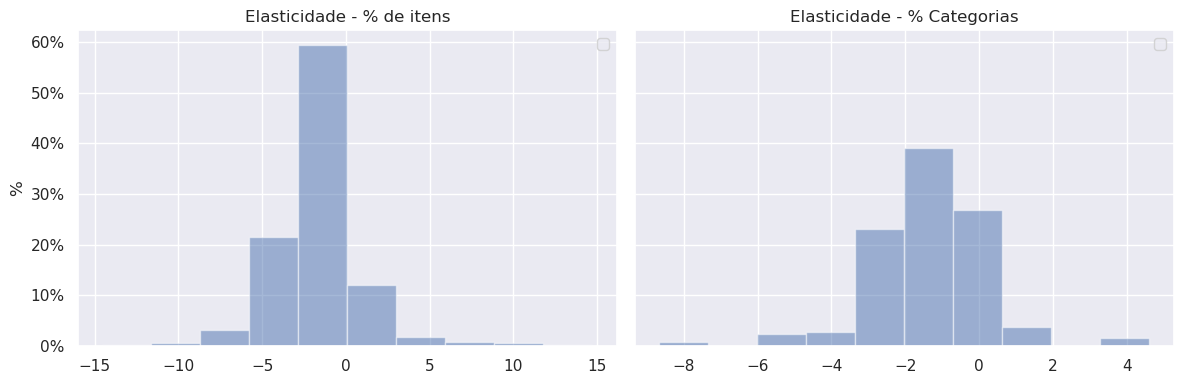

In [57]:


fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey = True)

# Plot for itens_selected_A_filter
axs[0].hist(
    itens_selected_A_filter["elasticity_price"],
    bins=10,
    alpha=0.5,
    label="",
    weights=np.ones(len(itens_selected_A_filter)) / len(itens_selected_A_filter),
)
axs[0].yaxis.set_major_formatter(PercentFormatter(1))
axs[0].legend(loc="upper right")
axs[0].set_ylabel("%")
axs[0].set_title("Elasticidade - % de itens")

# Plot for stats_elast_cat_A
axs[1].hist(
    stats_elast_cat_A["elasticity_price"],
    bins=10,
    alpha=0.5,
    label="",
    weights=np.ones(len(stats_elast_cat_A)) / len(stats_elast_cat_A),
)
axs[1].yaxis.set_major_formatter(PercentFormatter(1))
axs[1].legend(loc="upper right")
axs[1].set_ylabel("")
axs[1].set_title("Elasticidade - % Categorias")

plt.tight_layout()
plt.show()


### Melhoranbdo a inbterpretação

* Para o cálculo da elasticidade, considera-se apenas o módulo, pois para todo aumento de preço em bens normais, há uma redução da quantidade demandada.

* O sinal negativo serve apenas para representar está correlação negativa.

In [26]:
elast_cat_final_A = stats_elast_cat_A.abs()
# elast_cat_final[elast_cat_final['elasticity_price']< 1]
elast_cat_final_A

,elasticity_price,r2_score
categoria,,
A1 - BARBITURICO,0.49,0.02
A2 - BARBITURICO,1.19,0.15
A3 - BARBITURICO,0.33,0.02
ABSORVENTE EXTERNO,1.64,0.28
ABSORVENTE INTERNO,2.29,0.30
...,...,...
UNHAS E ACESSORIOS,0.56,0.06
UTILIDADES,0.55,0.18
VERRUGAS,1.79,0.05


## Strategy B: There are many factors that can drive the elasticity value of an item. 

#### Keep items where the degree of confidence in the model is greater than the overall average

In [27]:
itens_selected = results[results['r2_score']>= results['r2_score'].mean()]
print('Total itens:', len(itens_selected))


Total itens: 1353


Text(0.5, 1.0, 'Strategy B - Selected itens R2')

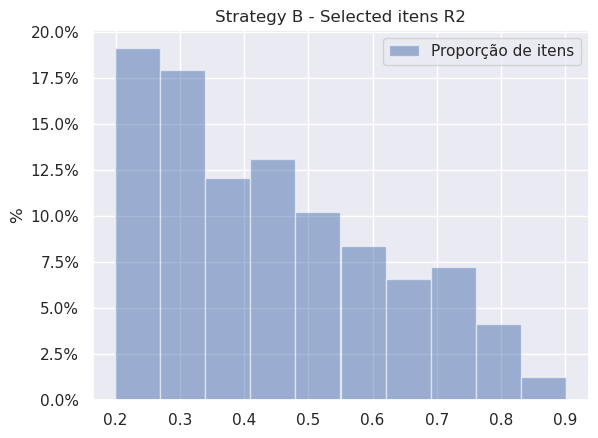

In [28]:
from matplotlib.ticker import PercentFormatter

plt.hist(
    itens_selected["r2_score"],
    bins=10,
    alpha=0.5,
    label="Proporção de itens",
    weights=np.ones(len(itens_selected)) / len(itens_selected),
)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend(loc="upper right")
plt.ylabel("%")
plt.title("Strategy B - Selected itens R2")

### Extract category elasticity

In [29]:
df_elast_cat = df_elast[['categoria', 'codigo_item']].drop_duplicates(subset=['codigo_item'], keep='first')
itens_selected = itens_selected.reset_index()
itens_selected.rename(columns={'index': 'codigo_item'}, inplace = True)


df_elast_cat = pd.merge(itens_selected, df_elast_cat,left_on='codigo_item', right_on = 'codigo_item' )

#Drop possible duplicates
# df.drop_duplicates(subset=['concat'], keep='first', inplace=True)
simple_stats(df_elast_cat)


Total datapoints: 1353

Total de items: 1353

Total de categorias: 172


In [30]:
stats_elast_cat = df_elast_cat.groupby(['categoria'], dropna=False, as_index=True, sort=True).agg(
    {
        "elasticity_price": ["mean"],
        "r2_score": ["mean"],
    }
)

stats_elast_cat .columns = stats_elast_cat.columns.droplevel(1)
# #stats_elast_cat.reset_index(inplace=True)
stats_elast_cat 

,elasticity_price,r2_score
categoria,,
A2 - BARBITURICO,-3.56,0.42
ABSORVENTE EXTERNO,-1.89,0.42
ABSORVENTE INTERNO,-2.17,0.38
ABSORVENTE PARA INCONTINENCIA FEMININO,0.31,0.31
ABSORVENTE PARA INCONTINENCIA MASCULINO,-1.11,0.21
...,...,...
TRATAMENTO AREAS ESPECIFICAS,-2.96,0.30
TRATAMENTOS DA PELE,-3.05,0.24
UNHAS E ACESSORIOS,-3.84,0.23


In [31]:
elast_cat_final = stats_elast_cat.abs()
# elast_cat_final[elast_cat_final['elasticity_price']< 1]
elast_cat_final

,elasticity_price,r2_score
categoria,,
A2 - BARBITURICO,3.56,0.42
ABSORVENTE EXTERNO,1.89,0.42
ABSORVENTE INTERNO,2.17,0.38
ABSORVENTE PARA INCONTINENCIA FEMININO,0.31,0.31
ABSORVENTE PARA INCONTINENCIA MASCULINO,1.11,0.21
...,...,...
TRATAMENTO AREAS ESPECIFICAS,2.96,0.30
TRATAMENTOS DA PELE,3.05,0.24
UNHAS E ACESSORIOS,3.84,0.23
